In [1]:
import math
import logging

import torch
import torch.nn as nn
from torch.nn import functional as F

import pytorch_lightning as pl

In [2]:
import d4rl
import gym
import numpy as np
import math
import logging

import torch
import torch.nn as nn
from torch.nn import functional as F


from torch.utils.data import Dataset
from torch.utils.data.dataloader import DataLoader

class PointmassBCDataset(Dataset):

    def __init__(self, name='maze2d-open-v0', block_size=64):
        
        self.block_size = block_size
        
        env = gym.make(name)
        self.data = env.get_dataset()
        self.obses = self.data['observations']
  
        self.acs = self.data['actions']
    
    
    def __len__(self):
        return len(self.obses) - self.block_size

    def __getitem__(self, idx):
        # grab a chunk of (block_size + 1) characters from the data
        obses = self.obses[idx:idx + self.block_size]
        acs = self.acs[idx:idx + self.block_size]
        
       
        
        obses = torch.tensor(obses, dtype=torch.float)
        acs = torch.tensor(acs, dtype=torch.float)
        return obses, acs
    
dataset = PointmassBCDataset()

loader = DataLoader(dataset, shuffle=True, pin_memory=True,
                                batch_size=512,
                                num_workers=4)


No module named 'flow'
INFO:absl:MUJOCO_GL=egl, attempting to import specified OpenGL backend.
INFO:absl:MuJoCo library version is: 200
No module named 'carla'
pybullet build time: Sep  1 2021 18:38:38
load datafile: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 19.89it/s]


In [3]:
obses, acs = next(iter(loader))
acs.shape

torch.Size([512, 64, 2])

In [4]:
acs.max()

tensor(1.)

In [5]:
torch.tril(torch.ones(4, 4))

tensor([[1., 0., 0., 0.],
        [1., 1., 0., 0.],
        [1., 1., 1., 0.],
        [1., 1., 1., 1.]])

In [6]:
torch.eye(4)

tensor([[1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.]])

In [11]:

class Attention(nn.Module):
    
    def __init__(self, conf):
        super().__init__()
        
        self.n_head = conf.n_head
        self.h_dim = h_dim = conf.h_dim
        max_T = conf.max_T
        self.qnet = nn.Linear(h_dim, h_dim)
        self.knet = nn.Linear(h_dim, h_dim)
        self.vnet = nn.Linear(h_dim, h_dim)
        
        self.proj = nn.Linear(h_dim, h_dim)
        
#         mask = torch.tril(torch.ones(max_T,max_T)).view(1,1,max_T,max_T)
        mask = torch.eye(max_T).view(1,1,max_T,max_T)
        self.register_buffer('mask',mask)
        
    def forward(self, x):
        # x is (B, T, C)
        assert x is not None
        B, T, C = x.shape
        N = self.n_head
        H = C // N
        assert C % N == 0
        
        q = self.qnet(x).view(B, T, N, H).transpose(1, 2)
        k = self.knet(x).view(B, T, N, H).transpose(1, 2)
        v = self.vnet(x).view(B, T, N, H).transpose(1, 2)
        
        att = q @ k.transpose(2, 3) * (1.0 / math.sqrt(H)) # (:, :, T, T)
        
#         att.att.masked_fill(self.mask[:,:,:T,:T] == 0, float('-inf'))
        att = att.masked_fill(self.mask[:,:,:T,:T] == 0, float('-inf'))
        
        att = F.softmax(att, dim=-1) # stays # (:, :, T, T)
        
        att = att @ v # (B, N, T, T) @ (B, N, T, H)
        
        # gather heads
        
        out = att.transpose(1, 2).contiguous().view(B, T, C)
        
        out = self.proj(out)
        return out
    
class Transformer(nn.Module):
    
    def __init__(self, config):
        super().__init__()
        
        h_dim = config.h_dim
        self.attention = Attention(config)
        self.ln1 = nn.LayerNorm(h_dim)
        self.mlp = nn.Sequential(
            nn.Linear(h_dim, 4*h_dim),
            nn.ReLU(),
            nn.Linear(4*h_dim, h_dim),
        )
        self.ln2 = nn.LayerNorm(h_dim)
        
    def forward(self, x):
        
        x = x + self.attention(x)
        x = self.ln1(x)
        x = x + self.mlp(x)
        x = self.ln2(x)
        
        return x
        

class GPT(nn.Module):
    
    def __init__(self, conf):
        super().__init__()

        # token embeddings
        vocab_dim = conf.in_dim
        h_dim = conf.h_dim
        obs_dim = conf.obs_dim
        ac_dim = conf.ac_dim
        self.obs_dim = obs_dim
                
        #self.token_embed = nn.Linear(vocab_dim, h_dim)
        
        self.pos_encoding = nn.Parameter(torch.zeros(1, 2*conf.max_T, h_dim))
        
        self.embed_obs = torch.nn.Linear(obs_dim, h_dim)
        self.embed_action = torch.nn.Linear(ac_dim, h_dim)
        
        # transformer
        self.transformer = nn.Sequential(*[Transformer(conf) for _ in range(conf.n_layer)])
        self.ln = nn.LayerNorm(h_dim)
        
        # prediction head
        self.pred_head = nn.Sequential(nn.Linear(h_dim, ac_dim), nn.Tanh()) # ac is -1 to 1 bounded
        
       
        # policy head
        # task_dim = 16
        # self.task_proj = nn.Sequential(nn.Linear(h_dim, task_dim), nn.ReLU())
        # self.policy_head = nn.Sequential(
        #    nn.Linear(task_dim + obs_dim, 4*task_dim),nn.ReLU(), nn.Linear(4*task_dim, ac_dim))
        
        self.apply(self._init_weights)
        
    def _init_weights(self, module):
        if isinstance(module, (nn.Linear, nn.Embedding)):
            module.weight.data.normal_(mean=0.0, std=0.02)
            if isinstance(module, nn.Linear) and module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)
            
        
    def forward(self, obs, acs):
        """
        What we want here a_t_pred = f(o_{t-k}, a_{t-k}, ..., o_{t-1}, a_{t}, o_{t})
        
        To do this we need to treat o and a as separate tokens and be careful about how we
        apply our mask
        
        - mask is used to get tau o_{t-k}, a_{t-k}, ..., o_{t-1}, a_{t}, o_{t}
        - then we'll predict single actions
        - we will want to repeat this with goal BC
        
        We want this to predict the next action so output should be (B, T, ac_dim)
        """
        
        B, T, _ = obs.shape
        
        obs_embeddings = self.embed_obs(obs)
        
        h_dim = obs_embeddings.shape[-1]
        action_embeddings = self.embed_action(acs)
        
        token_embeddings = torch.zeros((B, T*2, h_dim), dtype=torch.float32, device=obs_embeddings.device)
        
        token_embeddings[:,::2,:] = obs_embeddings
        token_embeddings[:,1::2,:] = action_embeddings
        
        
        pos_h = self.pos_encoding[:, :2*T, :]        
        
        h = token_embeddings + pos_h

        h = self.transformer(h)
        
        preds = self.pred_head(h)
        
        preds = preds[:, ::2, :]
        return preds, h
    
    def sample_action(self, obs, acs=None):
        B, T, _ = obs.shape
        
        obs_embeddings = self.embed_obs(obs)
        
        if acs is not None:
            h_dim = obs_embeddings.shape[-1]

            action_embeddings = self.embed_action(acs)

            token_embeddings = torch.zeros((B, T*2, h_dim), dtype=torch.float32, device=obs_embeddings.device)

            token_embeddings[:,::2,:] = obs_embeddings
            token_embeddings[:,1::2,:] = action_embeddings

        
            pos_h = self.pos_encoding[:, :2*T, :] 
            
        else:
            token_embeddings = obs_embeddings
            pos_h = self.pos_encoding[:, :T, :] 
        
        h = token_embeddings + pos_h

        h = self.transformer(h)
        
        preds = self.pred_head(h)
        
        preds = preds[:, ::2, :]
        return preds
    
    
    def z_behavior_clone(self, z, x, y):
        B, T, C = x.shape
        
        diag = torch.arange(T)
        
    
        
        obs = x[:,diag,:self.obs_dim]
        target_ac = y[:,diag, self.obs_dim:]
        
        z = self.task_proj(z)
        
        z_obs = torch.cat([obs, z], -1)
      
        pred_ac = self.policy_head(z_obs)
        return pred_ac, target_ac
    
    def behavior_clone(self, obs, acs, target_acs):
        B, T, C = obs.shape
        
        preds, _ = self.forward(obs, acs)
        
     
        return preds, target_acs
    
    
    def bc_loss(self, pred_ac, target_ac):
     
        pred_ac = pred_ac[:, 0].contiguous().view(-1, pred_ac.shape[-1])
        target_ac = target_ac[:, 0].contiguous().view(-1, target_ac.shape[-1])

        loss = F.mse_loss(pred_ac, target_ac)
        
        return loss
        
    
    def compute_loss(self, logits, targets):
        B, T, C = logits.shape
      
        
        logits = logits.view(-1, logits.shape[-1])
        targets = targets.view(-1, targets.shape[-1])
        loss = F.mse_loss(logits, targets)
        
        return loss
    


In [12]:
import tqdm 

class GPTConfig:
    """ base GPT config, params common to all GPT versions """
    embd_pdrop = 0.1
    resid_pdrop = 0.1
    attn_pdrop = 0.1
    
    

    def __init__(self, vocab_size=2, block_size=64, 
                 n_layer=4, n_head=8, n_embd=512, obs_dim=4, ac_dim=2):
        self.vocab_size = vocab_size
        self.block_size = block_size

        self.n_layer=n_layer
        self.n_head=n_head
        self.h_dim=n_embd 
        
        self.in_dim = vocab_size
        self.out_dim = vocab_size
        self.max_T = block_size
        
        self.obs_dim = obs_dim
        self.ac_dim = ac_dim
     
       

block_size = 64
conf = GPTConfig(6, 2*block_size,
                  n_layer=2, n_head=4, n_embd=256, obs_dim=4, 
                  )
model = GPT(conf)

weight_decay=1e-4
learning_rate=1e-4
betas=(0.99,0.999)
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, betas=betas)

device = torch.device('cuda')

model = model.to(device)

losses = []
epochs = 10

In [13]:
for epoch in range(epochs):
    pbar = tqdm.tqdm(enumerate(loader), total=len(loader)) if True else enumerate(loader)

    for it, (x, y) in pbar:

        # place data on the correct device
        x = x.to(device).float()

        y = y.to(device).float()

        # forward the model
        with torch.set_grad_enabled(True):
            #x = x.view(-1,x.shape[-1])
            #y = y.view(-1, y.shape[-1])
            
            pred_ac, _ = model.forward(x, y)

            loss = model.bc_loss(pred_ac, y)
            loss = loss.mean() # collapse all losses if they are scattered on multiple gpus
            losses.append(loss.item())
            model.zero_grad()
            loss.backward()
            optimizer.step()

        if it % 100 == 0:
            pbar.set_description(f'loss = {loss.item()}')

        #if it == 5000:
        #    break

loss = 0.24098697304725647:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 1746/1953 [03:13<00:22,  9.03it/s]


KeyboardInterrupt: 

0.21734309196472168


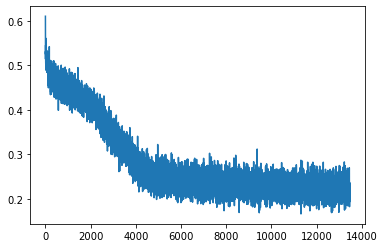

In [14]:
import matplotlib.pyplot as plt
plt.plot(losses)
print(losses[-1])

Global seed set to 10


[345353 760957 881167 443712 617841 105595 533660 927705 299741 804336
 108445 278385 960506 140296 795721 710912]


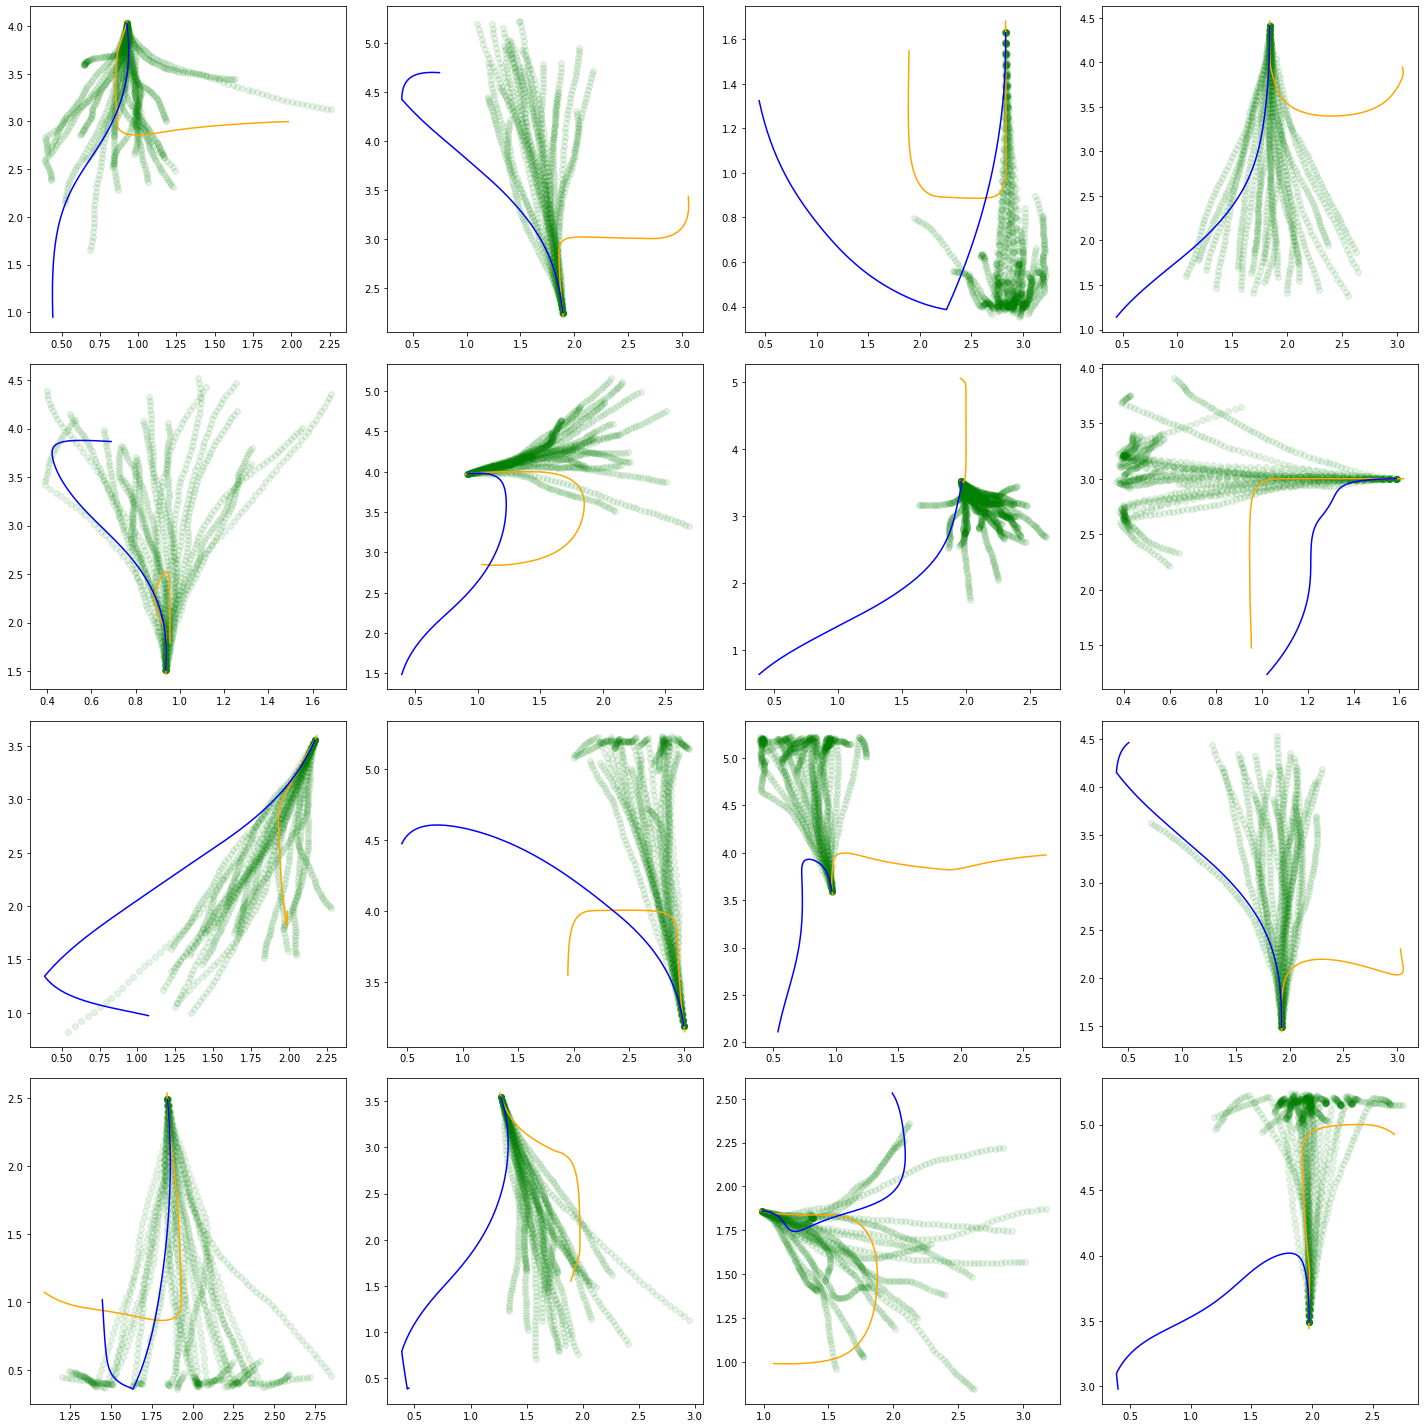

In [15]:
env = gym.make('maze2d-open-v0')

pl.seed_everything(10)
rand_idx = np.random.randint(0, len(dataset), size=(16,))
print(rand_idx)

x, y = [], []
for idx in rand_idx:
    xi, yi = dataset[idx]
    x.append(xi)
    y.append(yi)
x = torch.stack(x, 0)
y = torch.stack(y, 0)

x = x.to(device).float()

x_lims = [x[:,0].min().item(), x[:,0].max().item()]
y_lims = [x[:,1].min().item(), x[:,1].max().item()]

steps = 64

fig, axs = plt.subplots(4,4, figsize=(20, 20), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.001)
fig.tight_layout()
axs = axs.ravel()

# 12 21 28 29 33 34
for idx in range(16):

    
    qpos = x[idx][0][:2].detach().cpu().numpy()
    qvel = x[idx][0][2:4].detach().cpu().numpy()

    env.reset()
    env.set_state(qpos,qvel)

    rand = []
    for _ in range(20):
        env.reset()
        env.set_state(qpos,qvel)

        for _ in range(steps):
            s, r, d, _ = env.step(env.action_space.sample())
            rand.append(s[:2])

    osil = []

    for _ in range(1):
        env.reset()
        env.set_state(qpos,qvel)
        s = x[idx][0][:4] #.detach().cpu().numpy()
        
        obses = [s]
        acs = []
        
        for _ in range(steps):
            
            input_obs = torch.vstack([torch.as_tensor(o).to(device) for o in obses]).unsqueeze(0).float().to(device)
            input_acs = torch.vstack([torch.as_tensor(a).to(device) for a in acs]).unsqueeze(0).float().to(device) if len(acs) < 0 else None
            
            
            ac = model.sample_action(input_obs, input_acs)
            
            
            a = ac[0,-1].detach().cpu().numpy()
            
            s, r, d, _ = env.step(a)
            obses.append(s)
            acs.append(a)
            osil.append(s[:2])
            s = torch.as_tensor(s, dtype=x.dtype, device= x.device)

    osil = np.array(osil)

    rand = np.array(rand)
    #plt.scatter([qpos[0]],[qpos[1]])
    #plt.scatter(rand[:,0], rand[:,1], c='g',alpha=0.1)
    #plt.plot(osil[:steps,0], osil[:steps,1],c='b')
    #plt.plot(x[idx,:steps,0].detach().cpu().numpy(), x[idx,:steps,1].detach().cpu().numpy(),c='orange')
    #plt.show()
    axs[idx].scatter(rand[:,0], rand[:,1], c='g',alpha=0.1)
    axs[idx].plot(x[idx,:steps,0].detach().cpu().numpy(), x[idx,:steps,1].detach().cpu().numpy(),c='orange')
    axs[idx].plot(osil[:steps,0], osil[:steps,1],c='b')
    #axs[idx].set_xlim(*x_lims)
    #axs[idx].set_ylim(*y_lims)
    #axs[i].set_title(str(250+i))
    


In [30]:
torch.save({
            'epoch': 10,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': np.mean(losses[-100:])
            }, './goal_bc.pt')